HTRs are an imperfect and developing technology, with much of the difficulty relating to the variation in handwriting styles between people. We seek to add onto the development of HTRs, to it add a 
contextual RNN to predict whether the HTR's transcription is accurate.

Datasets: 
The HTR was trained using the IAM Handwriting Word Database, comprised of labeled images of handwriting by multiple authors
    Source -https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database
The RNN was trained using the Corpus of Linguistic Acceptability (CoLA) dataset, comprised of 10,000+ sentences labeled as either correct or incorrect grammatically
    Source- https://www.kaggle.com/datasets/krazy47/cola-the-corpus-of-linguistic-acceptability

# Data loading for HTR and Processing

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import opendatasets as od
import sys
import matplotlib as plt


# Path to the downloaded dataset
#od.download('https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database')
dataset_path = './iam-handwriting-word-database'
words_transcription_file = os.path.join(dataset_path, 'words_new.txt')
words_images_base_path = os.path.join(dataset_path, 'iam_words')

# Load transcriptions
transcriptions = {}
with open(words_transcription_file, 'r') as f:
    for line in f:
        if line.strip() and not line.strip().startswith('#'):
            parts = line.strip().split(' ')
            image_id = parts[0]
            transcription = parts[-1]
            transcriptions[image_id] = transcription
            #image_id, transcription = parts
           # transcriptions[image_id] = transcription.replace('|', ' ')

print(f"Loaded {len(transcriptions)} transcriptions.")

#prepare image paths and labels
image_paths = []
labels = []

print("Gathering image paths and labels...")
count = 0
max_examples = 10

for image_id, transcription in transcriptions.items():
    parts = image_id.split('-')
    if len(parts) >= 4:
        writer_id = parts[0]
        writer_page_num = parts[0] + '-' + parts[1]
        image_filename = f"{image_id}.png"

        relative_path_corrected = os.path.join('words', writer_id, writer_page_num, image_filename)
        full_image_path = os.path.join(words_images_base_path, relative_path_corrected)

        if count < max_examples:
            # print(f"Check path for image ID {image_id}: {full_image_path}")
            # print(f"Does path exist? {os.path.exists(full_image_path)}")
            print(f"transcription: {transcription}")
            print(f"image path: {full_image_path}")
            
            count += 1

        if os.path.exists(full_image_path):
            image_paths.append(full_image_path)
            
            labels.append(transcription)
 

print(f"Found {len(image_paths)} images with corresponding transcriptions.")
all_chars = sorted(list(set(''.join(labels))))
print("vocab: {all_chars}")
valid_image_paths = []
valid_labels = []
#check if files are empty or path leads to nothing
for path, label in zip(image_paths, labels):
    if not os.path.exists(path):
        print(f"Missing file: {path}")
        continue
    if os.path.getsize(path) == 0:
        print(f"Empty file (0 bytes): {path}")
        continue
    try:
        img_raw = tf.io.read_file(path)
        img = tf.io.decode_png(img_raw, channels=1)
        valid_image_paths.append(path)
        valid_labels.append(label)
    except Exception as e:
        print(f"Error loading {path}: {e}")

print(f"Valid files after cleanup: {len(valid_image_paths)}")

#only use paths that are confirmed
image_paths = valid_image_paths
labels = valid_labels


#create vocabulary: maps numbers to labels, and vice versa
all_chars = sorted(list(set(''.join(labels))))
char_to_num = tf.keras.layers.StringLookup(vocabulary=all_chars, mask_token=None, oov_token="[UNK]")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, oov_token="[UNK]", invert=True)

print(f"Vocabulary size: {len(all_chars)}")
print(f"Vocabulary: {all_chars}")


#preprocessing function
def process_data(image_path, label):
    image_path = tf.cast(image_path, tf.string)
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img_height = 64
    img_width = 256
    height, width = tf.shape(img)[0], tf.shape(img)[1]
    scale = tf.cast(img_height, tf.float32) / tf.cast(height, tf.float32)
    img_width_new = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
    img_width_new = tf.minimum(img_width_new, img_width)

    img = tf.image.resize(img, [img_height, img_width_new])
    img = tf.image.pad_to_bounding_box(img, 0, 0, img_height, img_width)

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return img, label


train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
#confirming labels and paths look proper
for i in range(10):
    print(f"Label {i}: {train_labels[i]}")
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))

#sets up optimal parallel processing
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_data, num_parallel_calls=AUTOTUNE)

print("\nData preprocessing complete")
print(f"Training dataset size: {tf.data.experimental.cardinality(train_ds).numpy()} batches")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_ds).numpy()} batches")

#Label padding setup
all_labels = train_labels + val_labels
max_label_len = max(len(label) for label in all_labels)
print(f"Max label length across dataset: {max_label_len}")


def prepare_for_ctc(img, label):
    input_len = tf.shape(img)[1] // 4  # must match the divisor of cnn output width and height (comes from 2^number of max pooling)
    label_len = tf.shape(label)[0]
    input_len = tf.expand_dims(input_len, axis=0)
    label_len = tf.expand_dims(label_len, axis=0)
    return img, label, input_len, label_len

#ctc_prep_map for model input/output formatting
def ctc_prep_map(img, label, input_len, label_len):
    return (
        {
            "image": img,
            "label": label,
            "input_length": input_len,
            "label_length": label_len
        },
        tf.zeros([1])  # Dummy output for loss
    )

# Define padded shapes
padded_shapes = (
    [64, 256, 1],     # image
    [max_label_len],  # label
    [1], # input_length
    [1]  # label_length
)

def has_valid_label(img, label):
    #just makes sure label exists and is not null
    return tf.greater(tf.shape(label)[0], 0)

train_ds = train_ds \
    .filter(has_valid_label) \
    .map(prepare_for_ctc, num_parallel_calls=AUTOTUNE) \
    .padded_batch(32, padded_shapes=padded_shapes, drop_remainder=True) \
    .map(ctc_prep_map, num_parallel_calls=AUTOTUNE) \
    .cache().prefetch(AUTOTUNE)

val_ds = val_ds \
    .filter(has_valid_label) \
    .map(prepare_for_ctc, num_parallel_calls=AUTOTUNE) \
    .padded_batch(32, padded_shapes=padded_shapes, drop_remainder=True) \
    .map(ctc_prep_map, num_parallel_calls=AUTOTUNE) \
    .cache().prefetch(AUTOTUNE)



Loaded 44564 transcriptions.
Gathering image paths and labels...
transcription: A
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-00.png
transcription: MOVE
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-01.png
transcription: to
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-02.png
transcription: stop
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-03.png
transcription: Mr.
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-04.png
transcription: Gaitskell
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-05.png
transcription: from
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-00-06.png
transcription: nominating
image path: ./iam-handwriting-word-database\iam_words\words\a01\a01-000u\a01-000u-01-00.png
transcription: any
image path: ./i

# HTR Model architecture and training


In [2]:
#Model

import tensorflow as tf
import numpy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, GRU, Bidirectional, Input, Lambda, SimpleRNN, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


img_height = 64
img_width = 256
num_classes = len(all_chars) + 1  # +1 for the CTC blank token

# Define the input shape (grayscale images)
input_shape = (img_height, img_width, 1)

# Input layers named to match your dataset keys exactly
input_img = Input(shape=input_shape, name='image')  # Matches 'image' key in dataset
labels = Input(name='label', shape=[None], dtype='int32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


#best working so far
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.3)(x)

# x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.3)(x)


# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.3)(x)


#Alexander's CNN
# x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(input_img)
# x = MaxPooling2D()(x)
# x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)

# Calculate shape after conv and pooling layers
#adjust this if architecture changes
cnn_output_height = img_height // 4  # 2 max pools with stride 2 → 64/4=16
cnn_output_width = img_width // 4    # 256/4=64
cnn_output_filters = 32

feature_dimension = cnn_output_height * cnn_output_filters 

# Reshape CNN output for RNN layers
x = Reshape(target_shape=(cnn_output_width, feature_dimension), name='reshape')(x)
#ValueError: The total size of the tensor must be unchanged. Received: input_shape=(4, 28, 128), target_shape=(64, 512)Cell Execution Error

#RNN
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True, kernel_initializer='he_normal'), name='gru1')(x)
x = Bidirectional(GRU(gru_units, return_sequences=True, kernel_initializer='he_normal'), name='gru2')(x)

#x = SimpleRNN(64, return_sequences=True, activation='relu', dropout=0.3)(x)
#x = SimpleRNN(64, return_sequences=True, activation='relu', dropout=0.3)(x)
# x = LSTM(128, dropout=0.4, return_sequences=True, recurrent_dropout=0.4)(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(32, activation='relu')(x)
# x = Dropout(0.4)(x)

#Output Layer
output = Dense(num_classes, activation='softmax', name='dense_output')(x)

# Clip labels so that no label exceeds num_classes-2 (max valid index)
# This is a safety step; ideally fix this in preprocessing
clipped_labels = Lambda(lambda y: tf.clip_by_value(y, 0, num_classes - 2), name='clip_labels')(labels)

# --- CTC Loss Function ---
def ctc_lambda_func(args):
    y_pred, y_true, input_len, label_len = args
    return K.ctc_batch_cost(y_true, y_pred, input_len, label_len)

# --- Define the Model for Training with CTC Loss ---
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [output, clipped_labels, input_length, label_length]
)

training_model = Model(
    inputs=[input_img, labels, input_length, label_length],
    outputs=loss_out
)

# Compile training model with dummy lambda loss (loss calculated inside Lambda layer)
adam_optimizer = Adam(learning_rate=0.001)
training_model.compile(optimizer=adam_optimizer, loss={'ctc': lambda y_true, y_pred: y_pred}, metrics=['accuracy'])


train_steps = tf.data.experimental.cardinality(train_ds).numpy()
val_steps = tf.data.experimental.cardinality(val_ds).numpy()

history = training_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=200,
    validation_steps=200,
)

# # Print the keys in history
# print("History keys:", history.history.keys())

# # loss, accuracy = model.evaluate(val_ds)
# # print(f"Accuracy: {accuracy} \t Loss: {loss}")

# plt.figure(figsize=(8, 4))
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.title(f'HTR Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(8, 4))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title(f'HTR Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Epoch 1/30

200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 210ms/step - accuracy: 0.0000e+00 - loss: 43.8591 - val_accuracy: 0.0000e+00 - val_loss: 14.9599
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - accuracy: 0.0000e+00 - loss: 14.7040 - val_accuracy: 0.0000e+00 - val_loss: 14.3767
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.0000e+00 - loss: 14.1037 - val_accuracy: 0.0000e+00 - val_loss: 13.9150
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.0000e+00 - loss: 14.0207 - val_accuracy: 0.0000e+00 - val_loss: 13.5425
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.0000e+00 - loss: 13.5255 - val_accuracy: 0.0000e+00 - val_loss: 13.3237
Epoch 6/30
114/200 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.0000e+00 - loss: 13.1408

C:\Users\ahirs\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.0000e+00 - loss: 13.0953 - val_accuracy: 0.0000e+00 - val_loss: 13.4159
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.0038 - loss: 13.2227 - val_accuracy: 0.0033 - val_loss: 13.0000
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 234ms/step - accuracy: 0.0154 - loss: 12.9617 - val_accuracy: 0.0347 - val_loss: 12.9064
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.0397 - loss: 12.6285 - val_accuracy: 0.0338 - val_loss: 12.7794
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - accuracy: 0.0426 - loss: 12.8766 - val_accuracy: 0.0450 - val_loss: 12.5777
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - accuracy: 0.0499 - loss: 12.5699 - val_accuracy: 0.0416 - val_loss: 12.3840
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.0517 - loss: 12.1689 - val_accuracy: 0.0464 - val_loss: 12.4445
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0

In [ ]:
print("Output shape:", output.shape)  # Should be (None, time_steps, num_classes)
print("Input length shape:", input_length.shape)  # Should be (None, 1)
print("Label shape:", labels.shape)
print("num classes: ", num_classes)
print("Max label length:", max(len(label) for label in train_labels))
for batch in train_ds.take(1):
    input_lengths = batch[0]['input_length']
    print("Sample input lengths:", input_lengths.numpy().flatten())

Output shape: (None, 32, 77)
Input length shape: (None, 1)
Label shape: (None, None)
num classes:  77
Max label length: 19
Sample input lengths: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32]


278/278 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.1138 - loss: 10.4426


C:\Users\ahirs\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


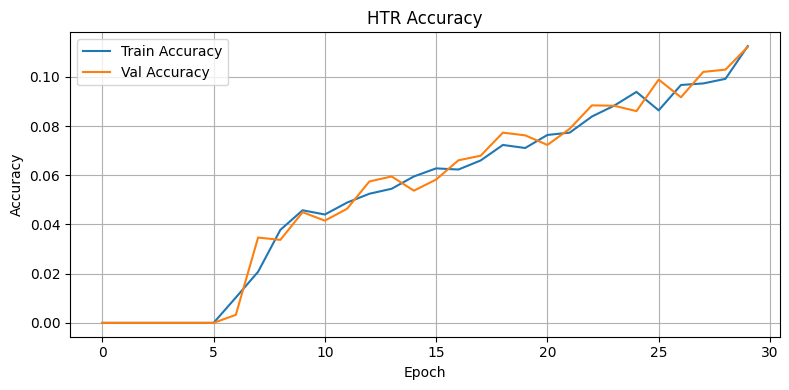

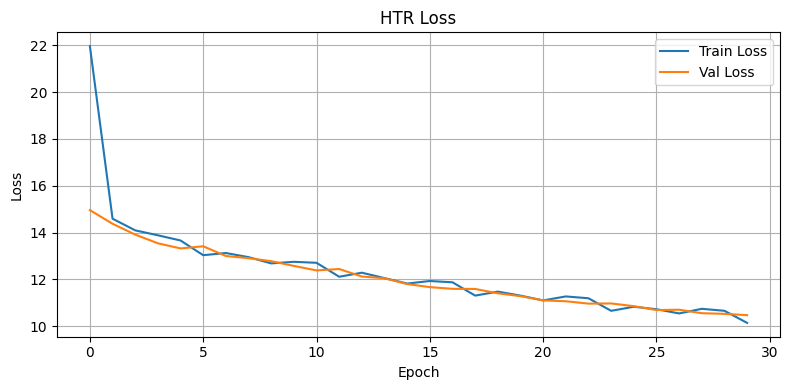

In [5]:

import matplotlib.pyplot as plt
loss, accuracy = training_model.evaluate(val_ds)

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title(f'HTR Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f'HTR Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict and Decode Predictions of HTR

In [6]:

def decode_ctc_predictions(predictions):
    decoded_texts = []
    for i in range(len(predictions)):
        pred = predictions[i]
 
        input_len = np.array([pred.shape[0]])
        decoded_sequences = tf.keras.backend.ctc_decode(
            np.expand_dims(pred, 0),
            input_len,
            greedy=True
        )[0][0]
        
        indices = decoded_sequences.numpy().flatten()
        text_chars = []
        
        for idx in indices:
            if idx > 0:  #skip blank tokens
                char = num_to_char([idx])  # pass as list
                if hasattr(char, 'numpy'):
                    char_bytes = char.numpy()
                    if isinstance(char_bytes, np.ndarray):
                        char_bytes = char_bytes[0]  # Get first element if array
                    
                    #convert bytes to string
                    if isinstance(char_bytes, bytes):
                        char = char_bytes.decode('utf-8')
                    else:
                        char = str(char_bytes)

                text_chars.append(char)
        
        # Join the characters
        text = ''.join([str(char) for char in text_chars])
        decoded_texts.append(text)
    
    return decoded_texts

# val_images = extract_images(val_ds)
val_images = val_ds.map(lambda inputs, outputs: inputs["image"])
prediction_model = Model( #copy trained model into an new one that doesn't need to take in labelss
    inputs=input_img,
    outputs=output
)
prediction_model.set_weights(training_model.get_weights()) #copy trained model to prediction model
prediction = prediction_model.predict(val_images)
predicted_words = decode_ctc_predictions(prediction)
#predicted_words = prediction.argmax(axis=1)




278/278 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step


# Output predicted words into sentences then to text file

In [8]:
for label, predicted_word in zip(val_labels, predicted_words):
    print(f"{predicted_word==label} \t predicted \"{label}\" - as \"{predicted_word}\"")

predicted_sentences = []
sentence = []
punctuation = [',',':',';','?','.','!','(',')', '[',']','{','}']
for i in range(len(predicted_words)):
    #if word is ending puncuation, add sentence to list and clear it
    word = predicted_words[i]
    if(word in ['?','.','!']):
        sentence.append(word)
        sentence = ''.join(sentence) #convert list to string sentence
        predicted_sentences.append(sentence)
        sentence = []
        continue
    #otherwise add it to list with a space
    sentence.append(word)
    try:
        #only add a space if the next word is not punctuation
        if(predicted_words[i+1] not in punctuation):
            sentence.append(" ")
    except Exception:
        #runs if i+1 causes index out of bounds. Do nothing
        pass

if sentence.count != 0: #last predicted sentence did not end with proper punctuation, add it to list of sentences
    sentence = ''.join(sentence)
    predicted_sentences.append(sentence)

for s in predicted_sentences:
    print(s)
with open("HTR_output.txt", "w") as text_file:
    for s in predicted_sentences:
        text_file.write(s)
        text_file.write("\n")

False 	 predicted "lead-based" - as "doe"
False 	 predicted "and" - as "ad"
False 	 predicted "most" - as "wot"
False 	 predicted "revised" - as "mold"
True 	 predicted "and" - as "and"
False 	 predicted "him" - as "tom"
True 	 predicted "the" - as "the"
True 	 predicted "." - as "."
False 	 predicted "He" - as "to"
False 	 predicted "all" - as "ait"
False 	 predicted "an" - as "on"
False 	 predicted "unwise" - as "coed"
True 	 predicted "and" - as "and"
True 	 predicted ")" - as ")"
True 	 predicted "the" - as "the"
True 	 predicted "-" - as "-"
False 	 predicted "peace" - as "pes"
False 	 predicted "team" - as "the"
True 	 predicted "," - as ","
True 	 predicted "a" - as "a"
False 	 predicted "bring" - as "bony"
False 	 predicted "gunwales" - as "foes"
False 	 predicted "generous" - as "pore"
False 	 predicted "retired" - as "moed"
False 	 predicted "ceramic" - as "comed"
True 	 predicted "a" - as "a"
False 	 predicted "impossible" - as "coet"
False 	 predicted ":" - as ","
False 	 p

# RNN data loading


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences


df = pd.read_csv('rnn_data.tsv', sep='\t', header=None)

#get column indices 1 and 3 for relevant data (1=label, 3=data)
rnn_train_labels = df.iloc[:, 1].astype(int)
rnn_train_texts = df.iloc[:, 3]

# rnn_train_texts, X_val, rnn_train_labels, y_val = train_test_split(
#      texts, labels, test_size=0.2, random_state=42, stratify=labels
#)

df = pd.read_csv('rnn_validation.tsv', sep='\t', header=None)
rnn_val_labels = df.iloc[:,1].astype(int)
rnn_val_texts = df.iloc[:,3]

df = pd.read_csv('rnn_test.tsv', sep='\t', header=None)
rnn_test_labels = df.iloc[:,1].astype(int)
rnn_test_texts = df.iloc[:,3]


all_texts = list(rnn_train_texts) + list(rnn_val_texts) + list(rnn_test_texts)
print(len(all_texts))

#build vocabulary on all the text it will see
tokenizer = Tokenizer(num_words=5829, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)
vocab_size = len(tokenizer.word_index) + 1

# Tokenize
rnn_train_sequences = tokenizer.texts_to_sequences(rnn_train_texts)
rnn_val_sequences = tokenizer.texts_to_sequences(rnn_val_texts)
rnn_test_sequences = tokenizer.texts_to_sequences(rnn_test_texts)

#map words to integers
max_len = 100
#tokenizer.fit_on_texts(rnn_train_texts)
#x_train_tokenized = tokenizer.texts_to_sequences(rnn_train_texts)
x_train_pad = pad_sequences(rnn_train_sequences, padding='post', maxlen=max_len)
x_train_pad, rnn_train_labels = shuffle(x_train_pad, rnn_train_labels, random_state=42)


#tokenizer.fit_on_texts(rnn_val_texts)
#x_val_tokenized = tokenizer.texts_to_sequences(rnn_val_texts)
x_val_pad = pad_sequences(rnn_val_sequences, padding='post', maxlen=max_len)
x_test_pad = pad_sequences(rnn_test_sequences, padding='post', maxlen=max_len)

print(f"Training samples: {len(rnn_train_texts)}")
print(f"Validation samples: {len(rnn_val_texts)}")
print(f"training shape {x_train_pad.shape}, label shape: {rnn_train_labels.shape}, label type: {rnn_train_labels.dtype}")
print(f"Vocab size: {vocab_size}")
print(f"Max train token: {x_train_pad.max()}")
print(f"Max val token: {x_val_pad.max()}")


9594
Training samples: 8551
Validation samples: 527
training shape (8551, 100), label shape: (8551,), label type: int64
Vocab size: 5829
Max train token: 5599
Max val token: 5701


In [67]:
for i in range(10):
    print(rnn_train_labels[i], "\t\t", rnn_train_sequences[i])

1 		 [205, 290, 233, 164, 29, 778, 779, 1252, 2, 780, 73, 26, 3829]
1 		 [73, 28, 2809, 2810, 11, 143, 1419, 50]
1 		 [73, 28, 2809, 2810, 130, 143, 1419, 50]
1 		 [2, 28, 26, 452, 2811, 2, 1420, 31, 185]
1 		 [453, 32, 453, 2, 3830, 47, 830, 3831]
1 		 [475, 729, 15, 4, 476]
1 		 [110, 1878, 2, 1118, 781]
1 		 [20, 680, 30, 234, 77, 9, 2, 1002]
1 		 [2271, 559, 2, 313, 408]
1 		 [681, 1879, 2, 905, 781]


# RNN Training and Evaluation

In [74]:
import pandas as pd
from tensorflow.keras.models import Sequential
from keras_hub.models import TextClassifier
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, Input, Embedding, Flatten, LSTM, GRU, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

weight_labels = [0,1]

weights = class_weight.compute_class_weight('balanced', classes=np.unique(rnn_train_labels), y=rnn_train_labels)
class_weights = dict(zip(np.unique(rnn_train_labels), weights))
#print(class_weights)


early = EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=5)


rnn_model = Sequential([
    # Embedding(input_dim=vocab_size, output_dim=64),
    # SimpleRNN(64, dropout=0.4, recurrent_dropout=0.4),
    # Dense(64, activation='relu'),
    # Dropout(0.2),
    # Dense(1, activation='sigmoid')
    
    #InputLayer(input_shape=(1,), dtype=tf.string),
    # Embedding(vocab_size, 64, mask_zero=True),  
    # Bidirectional(LSTM(64, return_sequences=True)), 
    # Bidirectional(LSTM(128)), 
    # Dense(64, activation='relu'),
    # Dense(1, activation='sigmoid')
    
    Embedding(vocab_size, 64, mask_zero=True),
    Bidirectional(LSTM(32, dropout=0.2, return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(SimpleRNN(64, return_sequences=False, activation='relu')),
    #SimpleRNN(32, return_sequences=True, activation='relu'),
    #SimpleRNN(64, return_sequences=False, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),  
    Dense(1, activation='sigmoid')

    # Embedding(input_dim=vocab_size, output_dim=64),
    # SimpleRNN(32, return_sequences=True, activation='relu', dropout=0.3),
    # SimpleRNN(64, return_sequences=True, activation='relu', dropout=0.3),
    # LSTM(128, dropout=0.4, recurrent_dropout=0.4),  # Increased dropout
    # Dense(128, activation='relu'),
    # Dense(64, activation='relu'),
    # Dropout(0.5),  # Increased dropout
    # Dense(32, activation='relu'),
    # Dropout(0.4),  # Add dropout here too
    # Dense(1, activation='sigmoid')
    
    # Embedding(vocab_size, 32),
    # Bidirectional(LSTM(64, recurrent_dropout=0.3)),
    # Dropout(0.5),
    # Dense(32, activation='relu'),
    # Dropout(0.5),
    # Dense(1, activation='sigmoid')

    # Embedding(vocab_size, 64),
    # LSTM(64, return_sequences=True, recurrent_dropout=0.3),
    # LSTM(128, return_sequences=False, recurrent_dropout=0.3),
    # Dense(32, activation='relu'),
    # Dropout(0.5),
    # Dense(1, activation='sigmoid')

])
    # Load a BERT classifier with pre-trained weights.
# classifier = TextClassifier.from_preset(
#     "bert_base_en",
#     num_classes=2,
# )
# classifier.fit((rnn_train_texts, rnn_train_labels), validation_data=(rnn_val_texts, rnn_val_labels))

rnn_model.compile(optimizer=Adam(0.0005), loss=BinaryCrossentropy(), metrics=['accuracy'])
history_rnn = rnn_model.fit(x_train_pad, rnn_train_labels, validation_data=(x_val_pad, rnn_val_labels),epochs=50, batch_size=32, callbacks=early, class_weight=class_weights)


#tokenize and padd evaluation data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_val)
# x_val_tokenized = tokenizer.texts_to_sequences(X_val)
# x_val_pad = pad_sequences(x_val_tokenized, padding='post')
loss, accuracy = rnn_model.evaluate(x_test_pad, rnn_test_labels)
print(f"Accuracy: {accuracy} \t Loss: {loss}")



Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 151ms/step - accuracy: 0.6472 - loss: 0.6926 - val_accuracy: 0.6053 - val_loss: 0.6906
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5993 - loss: 0.6775 - val_accuracy: 0.4858 - val_loss: 0.7139
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.6880 - loss: 0.5819 - val_accuracy: 0.5598 - val_loss: 0.7329
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.7575 - loss: 0.4840 - val_accuracy: 0.5674 - val_loss: 0.8153
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8001 - loss: 0.3979 - val_accuracy: 0.5465 - val_loss: 0.9511
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.8303 - loss: 0.3328 - val_accuracy: 0.5560 - val_loss: 1.0299
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5393 - loss: 0.6925
Accuracy: 0.5581395626068115 	 Loss: 0.6920011043548584


# RNN Plotting

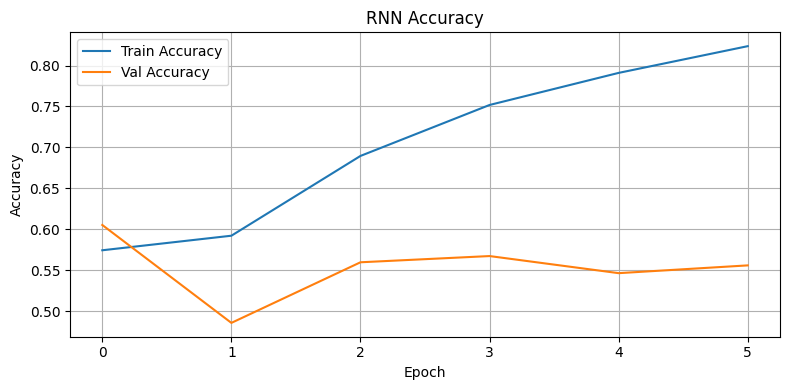

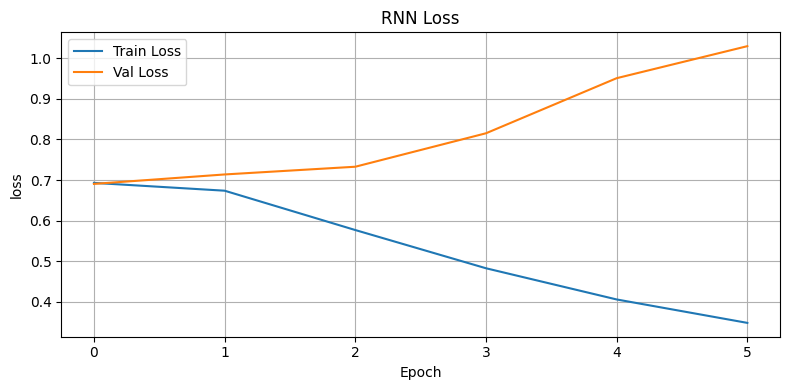

In [75]:
plt.figure(figsize=(8, 4))
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title(f'RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title(f'RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Run HTR transcriptions through RNN for context checking

In [ ]:
import enchant
valid_words = enchant.Dict("en_US") #list of valid english words
tokenizer.fit_on_texts(predicted_sentences)
prediction_tokenized = tokenizer.texts_to_sequences(predicted_sentences)
prediction_pad = pad_sequences(prediction_tokenized, padding='post')
rnn_prediction = rnn_model.predict(prediction_pad)

validation_predictions = rnn_model.predict(x_test_pad)
sentences_to_check = []
counter = 1

def all_real_words(sentence): #evaluates a sentence to see if it contains a "word" that is not real
    words = sentence.split()
    print(sentence)
    for word in words:
        word = word.strip()
        if word[-1] in punctuation:
            if len(word) == 1: #skip iteration if word is only punctuation
                continue
            word = word[:-1]
        if word is None or len(word) == 0 or word == " ":
            continue
        if not valid_words.check(word):
            
            return False #fake word found - potential bad transcription
    return True #no invalid words were found, 


for predicted_line, assurity in zip(predicted_sentences, rnn_prediction):
    #print(f"{assurity*100}% that \"{predicted_line}\" is correct")
    if not all_real_words(predicted_line): #Mark line for manual check if not atleast 75% confident it was correctly transcribed
        sentences_to_check.append(counter)
        counter = counter + 1

        
#Inform user what line to check manually
for i in range(len(sentences_to_check)):
    print(f"Line {sentences_to_check[i]} did not meet the confidence threshhold -- please check manually")



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
doe ad wot mold and tom the.
value passing into check: doe !
value passing into check: ad !
value passing into check: wot !
value passing into check: mold !
value passing into check: and !
value passing into check: tom !
the. ends with punc
value passing into check: the !
to ait on coed and) the - pes the, a bony foes pore moed comed a coet, hoe Te coie Bos tot of foe the thr the oy sees thn dony of wot ahn toe the of and ", pret fos fay tot of wod siies she and " for the " aoh, The tht the.
value passing into check: to !
value passing into check: ait !
value passing into check: on !
value passing into check: coed !
and) ends with punc
value passing into check: and !
value passing into check: the !
value passing into check: - !
fake word:  -
of The pared a fot the, toes fot, i coie and wid ay fr the of fhns monoen and.
value passing into check: of !
value passing into check: The !
value passing into check: 